# SVM classification

### PROs
The advantages of support vector machines are:
 - effective in high dimensional spaces.
 - still effective in cases where number of dimensions is greater than the number of samples.
 - uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
 - versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

### CONs
 - If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
 - SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

---

Here we perform classification using Support Vector Machines.

It is necessary to do different tests trying to tune the hyperparameters and doing the best possible pre-processing. 

Regarding Pre-Processing, it is necessary to select:
 - the best scaling strategy, necessary pre-processing step for the SVM classifier;
 - the best feature selection/feature extraction method. Try with:
    - PCA (feature extraction for dimensionality reduction);
    - Filter methods such as SelectKBest, SelectPercentile. The metric to use should be the f_classif (ANOVA correlation since attributes are numerical and targets are categorical).
- the best way to balance out the classes:
    - Oversampling;
    - Undersampling;
    - built-in methods used by SVC class.
- the best way to remove the outliers.
    
Regarding the classification, it is necessary to select:
 - the kernel function of the SVM (linear, polynomial, rbf, sigmoid) and the respective parameters (e.g. gamma for the rbf);
 - the regulatization parameter;
 - the multiclassification method (ovo or ova);
 
 Regarding the training procedure, it is necessary to select:
  - the best train\test split

In [2]:
# LIBRARIES

import numpy as np
import pandas as pd

from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings

from mpl_toolkits.mplot3d import Axes3D
from pandas._libs import json
import sklearn.decomposition as dec
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import UndefinedMetricWarning
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
import sklearn.metrics as met
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline 

%matplotlib inline

## Pre-processing

Includes different feature selection methods other than class balaninc methods. Every method returns a different dataset that can be used with the SVM classification.

### Class balancing

In [3]:
def class_balancing(X_train, y_train, method):
    
    if method == 'smote':
        sampler = SMOTE()
    elif method == 'adasyn':
        sampler = ADASYN()
    elif method == 'smote_tomek':
        sampler = SMOTETomek()
    elif method == 'smote_enn':
        sampler = SMOTEENN()
    
    X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

    return X_train_resampled, y_train_resampled

## SVM classification

The machine learning pipeline has the following steps: preparing data, creating training/testing sets, instantiating the classifier, training the classifier, making predictions, evaluating performance, tweaking parameters.


In [72]:
def parameters_estimation(pipe, X_train, X_test, y_train, y_test, n_cv, scores):

    # Set the parameters by cross-validation
    tuned_parameters = [
        {
            'classifier__kernel': ['rbf'],
         
        #  'gamma': np.logspace(-1, 3, 3), # COARSE RANGE
            'classifier__gamma': [0.05, 0.1], # FINE RANGE
            # where 'auto' is the value 1 / n_features
            # by default gamma is set to 'scale', i.e. 1 / (n_features * X.var())
         
        #  'C': np.logspace(-1, 3, 3), # COARSE RANGE
            'classifier__C': [100], # FINE RANGE
            # by default C is set to # 1
            'classifier__decision_function_shape': ['ovo']},  # by default this is set to ovr

        # {   
        #     'classifier__kernel': ['linear'],
        #     'classifier__C': [1, 10, 100, 1000],
        #     'classifier__decision_function_shape': ['ovo']}, 
    ]

    # Creates an empty dictionary with best parameters for every scoring parameter considered
    best_parameters = {key: None for key in scores}


    # Cross-validation **for every score!**
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            estimator = pipe,
            param_grid = tuned_parameters,
            scoring = score,
            n_jobs = -1,
            verbose = 4,
            return_train_score = True,
            cv = n_cv
            )

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            clf.fit(X_train, y_train)


        # PLOTTING CROSS VALIDATION RESULTS:

        print("\nBest parameters set found on development set:\n")
        print(clf.best_params_)
        best_parameters[score] = clf.best_params_

    
        print("\nGrid scores on development set:\n")
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%r: %0.3f (+/-%0.03f) for %r"
                  % (score, mean, std * 2, params))


        # FINAL CLASSIFICATION ON TEST SET WITH BEST PARAMETERS (THAT MAXIMISE THE CURRENT SCORE) AND PLOTTING RESULTS
        
        print("\nDetailed classification report:\n")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.\n")
        
        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
        print()

        
        fig, ax = plt.subplots(111, figsize=(10,10), dpi=120)
        
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        ax = sns.heatmap(cm, annot=True)
        # set x-axis label and ticks. 
        ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
        ax.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        # set y-axis label and ticks
        ax.set_ylabel("Actual Class", fontsize=14, labelpad=20)
        ax.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])

        # set plot title
        ax.set_title('Result obtained with parameters maxmimizing' + score)
    
    return best_parameters

In [76]:
def svc_classification(pipe, X_train, X_test, y_train, y_test, best_parameters, selected_score):
    
    # Print the best parameters configurations that maximise specific metric/scores
    print("List of the parameters used according to a specific scoring parameter:")
    print(json.dumps(best_parameters, indent=4))
    print()

    # # Add a specific parameter to the configuration in order to show iterations
    # for i in best_parameters:
    #     best_parameters[i]['verbose'] = 0
    #     # More info on the 'verbose' parameter:
    #     # The verbosity level: if non zero, progress messages are printed. Above 50, the output is sent to stdout.
    #     # The frequency of the messages increases with the verbosity level. If it more than 10, all iterations are
    #     # reported.
    #     # verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch

    # Final classification with optimized parameters:
    print("SVM Classification:")
    print("Parameters set in order to maximise the %s scoring parameter" % selected_score.upper())

    # Instantiate a new classifier object with best parameters for a selected scoring parameter
    clf = pipe
    clf.set_params(**best_parameters[selected_score])
    # Alternative: creating a new classifier object with manually selected parameters, not optimized
    # clf = SVC(kernel='rbf', decision_function_shape='ovo', verbose=2)

    # Model training:
    print("Model training:")
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        clf.fit(X_train, y_train)

    # Model testing:
    print("\n\nMaking predictions:")
    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
        # .. your divide-by-zero code ..
        y_predicted = clf.predict(X_test)

        # Performance evaluation
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_predicted))
        print()

        print(classification_report(y_test, y_predicted))
        print()

    fig, ax = plt.subplots(111, figsize=(10,10), dpi=120)
    cm = confusion_matrix(y_test, y_predicted, normalize='true')
    ax = sns.heatmap(cm, annot=True)
    # set x-axis label and ticks. 
    ax.set_xlabel("Predicted Class", fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
    # set y-axis label and ticks
    ax.set_ylabel("Actual Class", fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
    # set plot title
    ax.set_title('Result obtained with parameters maxmimizing' + selected_score)
    
    return clf

## Testing

In [74]:
# Import dataset
df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
X = df[df.columns.tolist()[:-1]]
y = df["Class"]

# Train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# Class balancing (NOT GOOD TO DO IT HERE IF I DO CROSS VALIDATION AFTER!)
# X_train, y_train = class_balancing(X_train, y_train, method='smote_enn')

# # Feature Scaling 
# sc = StandardScaler()
# X_train_scaled = sc.fit_transform(X_train)
# X_test_scaled = sc.transform(X_test)    

# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/samuponz/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.05, classifier__kernel=rbf;, score=(train=0.945, test=0.927) total time=   1.3s
[CV 1/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.05, classifier__kernel=rbf;, score=(train=0.941, test=0.928) total time=   1.4s
[CV 3/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.05, classifier__kernel=rbf;, score=(train=0.943, test=0.929) total time=   1.2s
[CV 4/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.05, classifier__kernel=rbf;, score=(train=0.945, test=0.928) total time=   1.2s


4789.34s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4790.39s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV 5/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.05, classifier__kernel=rbf;, score=(train=0.944, test=0.931) total time=   1.2s
[CV 1/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.1, classifier__kernel=rbf;, score=(train=0.948, test=0.924) total time=   1.3s


4791.17s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4792.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
4792.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV 3/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.1, classifier__kernel=rbf;, score=(train=0.949, test=0.925) total time=   1.7s


4793.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV 4/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.1, classifier__kernel=rbf;, score=(train=0.952, test=0.925) total time=   1.8s
[CV 2/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.1, classifier__kernel=rbf;, score=(train=0.951, test=0.921) total time=   2.0s
[CV 5/5] END classifier__C=100, classifier__decision_function_shape=ovo, classifier__gamma=0.1, classifier__kernel=rbf;, score=(train=0.951, test=0.925) total time=   1.6s

Best parameters set found on development set:

{'classifier__C': 100, 'classifier__decision_function_shape': 'ovo', 'classifier__gamma': 0.05, 'classifier__kernel': 'rbf'}

Grid scores on development set:

'accuracy': 0.928 (+/-0.003) for {'classifier__C': 100, 'classifier__decision_function_shape': 'ovo', 'classifier__gamma': 0.05, 'classifier__kernel': 'rbf'}
'accuracy': 0.924 (+/-0.003) for {'classifier__C': 100, 'classifier__decision_function_shape': 'ovo', 'classifier__gamm

ValueError: The number of FixedLocator locations (0), usually from a call to set_ticks, does not match the number of labels (7).

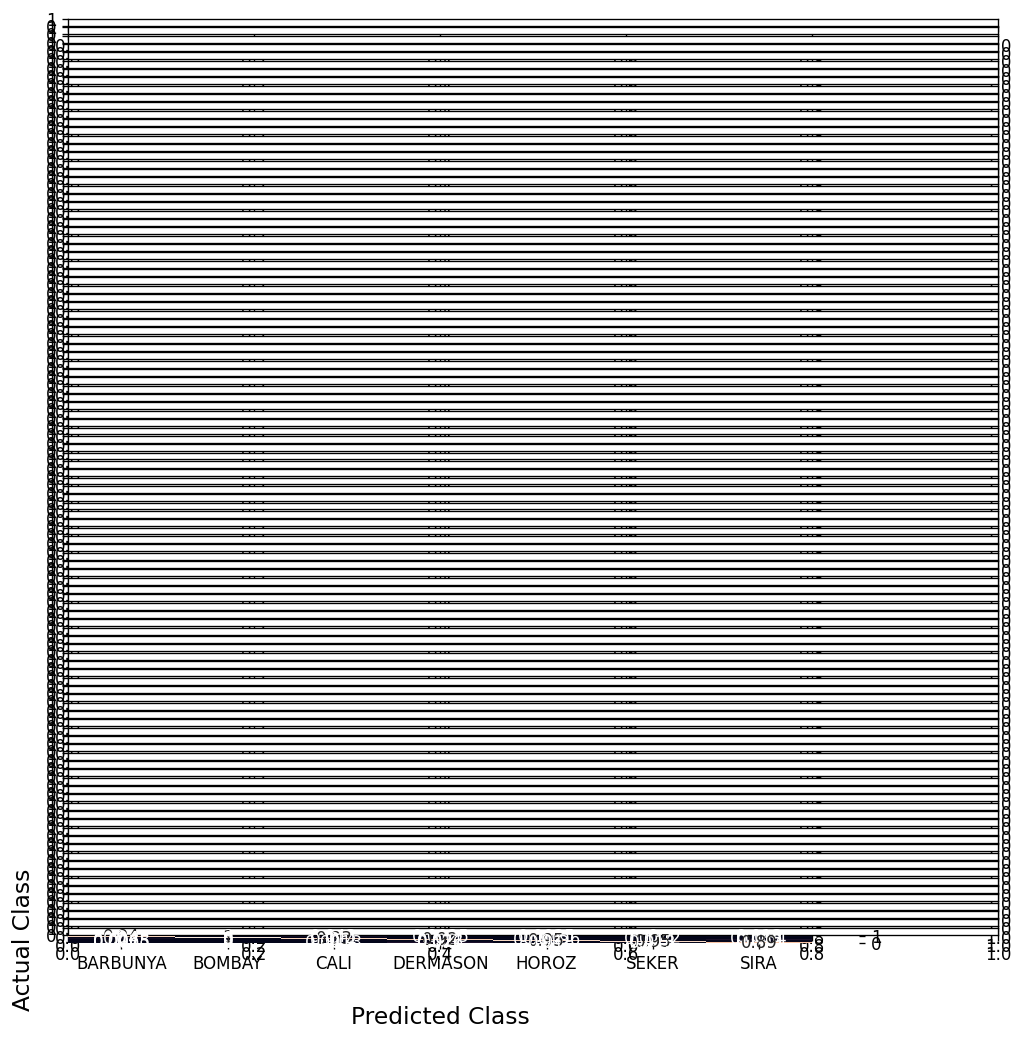

In [75]:
# Hyper-parameter optimization using k-fold cross validation: estimation of the classifier's parameters that maximise specific metrics/scores

pipe = Pipeline([['scaler', StandardScaler()], ['over', SMOTE()], ['classifier', SVC()]])  # [None, SMOTE(), ADASYN(), SMOTETomek(), SMOTEENN()]
cv = 5
# scores = ['accuracy']
scores = ['accuracy', 'precision_macro']
# scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

best_parameters = parameters_estimation(pipe, X_train, X_test, y_train, y_test, cv, scores);

In [29]:
best_parameters['accuracy']

{'classifier__C': 100,
 'classifier__decision_function_shape': 'ovo',
 'classifier__gamma': 0.05,
 'classifier__kernel': 'rbf'}

List of the parameters used according to a specific scoring parameter:
{
    "accuracy":{
        "classifier__C":100,
        "classifier__decision_function_shape":"ovo",
        "classifier__gamma":0.05,
        "classifier__kernel":"rbf"
    },
    "precision_macro":{
        "classifier__C":100,
        "classifier__decision_function_shape":"ovo",
        "classifier__gamma":0.05,
        "classifier__kernel":"rbf"
    },
    "recall_macro":{
        "classifier__C":100,
        "classifier__decision_function_shape":"ovo",
        "classifier__gamma":0.05,
        "classifier__kernel":"rbf"
    },
    "f1_macro":{
        "classifier__C":100,
        "classifier__decision_function_shape":"ovo",
        "classifier__gamma":0.05,
        "classifier__kernel":"rbf"
    }
}

SVM Classification:
Parameters set in order to maximise the ACCURACY scoring parameter
Model training:


Making predictions:
Confusion Matrix:
[[369   0  19   0   1   2   4]
 [  0 161   0   0   0   0   0]
 [ 17   0

/home/samuponz/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


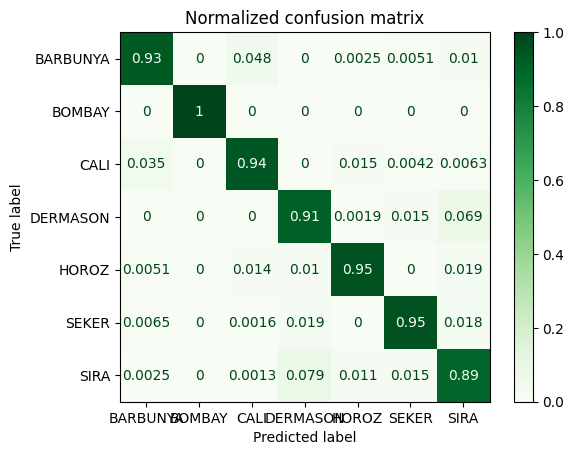

In [34]:
# Final classification (on test set)

# selection of a particular configuration: this is done selecting the relative metric
selected_score = "accuracy"

svm_clf = svc_classification(pipe, X_train, X_test, y_train, y_test, best_parameters, selected_score)

## PIPELINE: testing different scaling methods and feature selection methods

In [ ]:
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have a full-blown estimator

clf = Pipeline(
    [
        ("anova", SelectPercentile(f_classif)), # Metric is ANOVA
        ("scaler", MinMaxScaler()),
        ("svc", SVC(gamma="auto")),
    ]
)

In [ ]:
# This takes 2 minutes

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title("Performance of the SVM-Anova varying the percentile of features selected")
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel("Percentile")
plt.ylabel("Accuracy Score")
plt.axis("tight")

### Comments

It seems with both standard and minmax scaling, the accuracy increments using more features.

## NAIVE CLASSIFICATION: multiple classifiers compared

In [ ]:
def naive_classification(df):

    df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
    df_traindata, df_trainlabel = df_train.iloc[:, 0:len(df_train.columns) - 1], df_train.iloc[:, -1]
    df_testdata, df_testlabel = df_test.iloc[:, 0:len(df_test.columns) - 1], df_test.iloc[:, -1]

    warnings.filterwarnings('ignore')
    # Baseline - comparing model accuracy using all features across classifiers
    classifiers = [
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(),
        SVC(),
        GaussianNB(),
        LogisticRegression()
    ]

    # Naive Train Accuracy
    algo = ['DTC', 'RFC', 'KNN', 'SVC', 'GNB', 'LR']
    # algo = []
    scores = []
    for clf in classifiers:
        # algo.append(clf.__class__.__name__)
        scores.append(cross_val_score(clf, df_traindata, df_trainlabel, cv=5).mean())
    warnings.filterwarnings('ignore')
    Naivescore_df_Train = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Naive Test Accuracy
    algo = ['DTC', 'RFC', 'KNN', 'SVC', 'GNB', 'LR']
    # algo = []
    scores = []

    for clf in classifiers:
        clf = clf.fit(df_traindata, df_trainlabel)
        y_pred = clf.predict(df_testdata)
        # algo.append(clf.__class__.__name__)
        scores.append(accuracy_score(y_pred, df_testlabel))
    warnings.filterwarnings('ignore')
    Naivescore_df_Test = pd.DataFrame({'Algorithm': algo, 'Score': scores}).set_index('Algorithm')

    # Bar plot between Train and Test Accuracy
    fig = plt.figure(figsize=(5, 5))  # Create matplotlib figure

    ax = fig.add_subplot(111)  # Create matplotlib axes
    ax2 = ax.twinx()  # Create another axes that shares the same x-axis as a
    width = .3

    Naivescore_df_Train.Score.plot(kind='bar', color='green', ax=ax, width=width, position=0)
    Naivescore_df_Test.Score.plot(kind='bar', color='red', ax=ax2, width=width, position=1)

    ax.grid(None, axis='y')
    ax2.grid(None)

    ax.set_ylabel('Train')
    ax2.set_ylabel('Test')

    ax.set_xlim(-1, 6)

## Comparison: Random Forests and KNN

In [ ]:
def rf_classification(x, y):

    # Splitting the dataset:
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # # Quick implementation: --------------------------------------------
    # # Create a Gaussian Classifier
    # clf = RandomForestClassifier(n_estimators=100)
    #
    # # Train the model using the training sets y_pred=clf.predict(X_test)
    # clf.fit(X_train, y_train)
    #
    # y_pred = clf.predict(X_test)
    # # Model Accuracy, how often is the classifier correct?
    # print("Accuracy:", accuracy_score(y_test, y_pred))
    # print()
    # # ------------------------------------------------------------------

    # Set the parameters by cross-validation
    tuned_parameters = [
        {'n_estimators': [350, 400, 450, 500],
            'max_depth': [2, 5, 7, 9, 20, 50, 100]}
    ]

    scores = ['accuracy']
    # scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # Creates a dictionary with best parameters for every scoring parameter considered
    # best_parameters = {key: None for key in scores}

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            RandomForestClassifier(), tuned_parameters, scoring=score, cv=5
        )

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%r: %0.3f (+/-%0.03f) for %r"
                  % (score, mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
        print()

        print(clf.best_params_)
        # best_parameters[score] = clf.best_params_

In [ ]:
def knn_classification(x, y):

    # Splitting the dataset:
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=42)

    # Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # # Quick implementation: --------------------------------------------
    # # Create a Gaussian Classifier
    # clf = RandomForestClassifier(n_estimators=100)
    #
    # # Train the model using the training sets y_pred=clf.predict(X_test)
    # clf.fit(X_train, y_train)
    #
    # y_pred = clf.predict(X_test)
    # # Model Accuracy, how often is the classifier correct?
    # print("Accuracy:", accuracy_score(y_test, y_pred))
    # print()
    # # ------------------------------------------------------------------

    # Set the parameters by cross-validation
    tuned_parameters = [
        {'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'n_neighbors': [5, 10, 15]}
    ]

    scores = ['accuracy']
    # scores = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

    # Creates a dictionary with best parameters for every scoring parameter considered
    # best_parameters = {key: None for key in scores}

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            KNeighborsClassifier(), tuned_parameters, scoring=score, cv=5
        )

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%r: %0.3f (+/-%0.03f) for %r"
                  % (score, mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()

        # ignore divide-by-zero warnings, these occur inevitably in the parameter estimation phase and are annoying
        with warnings.catch_warnings():
            warnings.filterwarnings(action="ignore", category=UndefinedMetricWarning)
            # .. your divide-by-zero code ..
            y_true, y_pred = y_test, clf.predict(X_test)
            print(classification_report(y_true, y_pred))
        print()

        print(clf.best_params_)
        # best_parameters[score] = clf.best_params_